In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable

# First

Gatys, Leon A., Alexander S. Ecker, and Matthias Bethge. "Image style transfer using convolutional neural networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

In [ ]:
style_img = Image.open('/content/drive/MyDrive/image/solen-feyissa-s_niwAd9PJ8-unsplash.jpg')
content_img = Image.open('/content/drive/MyDrive/image/content_img.jpg')

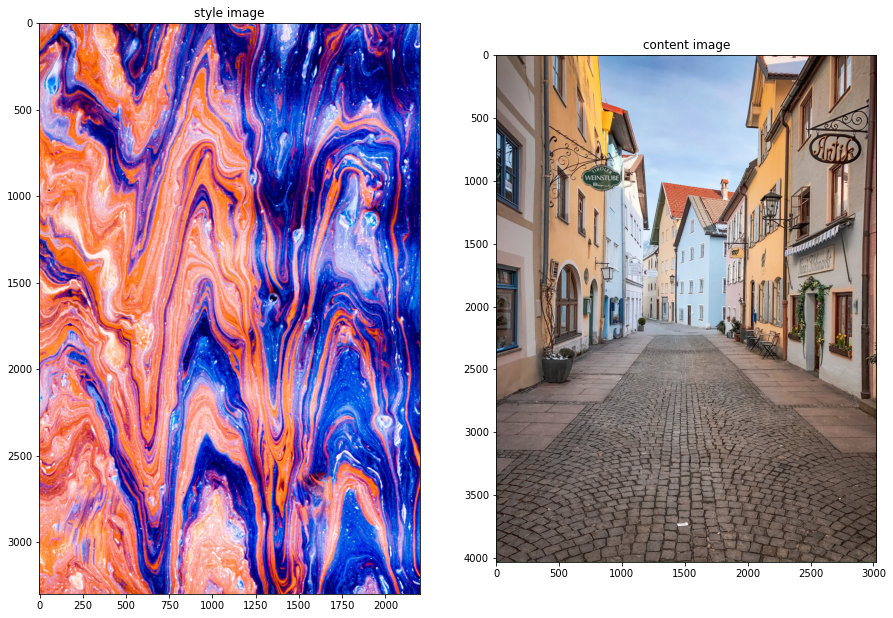

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [ ]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg19(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [ ]:
vgg.vgg19(pretrained=True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
loss_net = LossNetwork().cuda()
for param in loss_net.parameters():
    param.requires_grad = False

In [ ]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '8': "conv2-2"
}

content_layer_name_2 = {
    '22': "conv4-2"
}

In [ ]:
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [ ]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True

out_img_2 = content.clone()
out_img_2.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]
content_gt_2 = [A.detach() for A in loss_net(content, content_layer_name_2).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
optimizer_2 = optim.LBFGS([out_img_2])
n_iter = [0]

In [ ]:
alpha = 1e0
beta = 1e8
max_iter = 500

In [ ]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)

Iteration: 50, loss: 38.584522
Iteration: 100, loss: 11.397705
Iteration: 150, loss: 6.785063
Iteration: 200, loss: 4.762006
Iteration: 250, loss: 3.921679
Iteration: 300, loss: 3.436982
Iteration: 350, loss: 3.093905
Iteration: 400, loss: 2.872254
Iteration: 450, loss: 2.731480
Iteration: 500, loss: 2.627295


In [ ]:
n_iter = [0]
content_loss = 0
while n_iter[0] <= max_iter:

    def closure():
        optimizer_2.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img_2, style_layer_name).values()]
        content_layers_2 = [f for f in loss_net(out_img_2, content_layer_name_2).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers_2[0], content_gt_2[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer_2.step(closure)

Iteration: 50, loss: 40.752529
Iteration: 100, loss: 15.218277
Iteration: 150, loss: 10.484062
Iteration: 200, loss: 8.307133
Iteration: 250, loss: 7.369487
Iteration: 300, loss: 6.819111
Iteration: 350, loss: 6.414105
Iteration: 400, loss: 6.145704
Iteration: 450, loss: 5.967007
Iteration: 500, loss: 5.835444


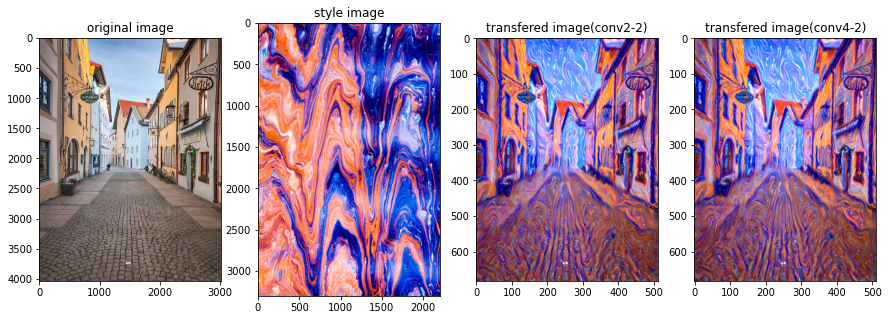

In [ ]:
final_img = post(out_img.data[0].cpu().squeeze())
final_img_2 = post(out_img_2.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,4,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,4,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,4,3)
plt.title('transfered image(conv2-2)')
plt.imshow(final_img)
plt.subplot(1,4,4)
plt.title('transfered image(conv4-2)')
plt.imshow(final_img_2)
plt.show()

# Second

Johnson, Justin, Alexandre Alahi, and Li Fei-Fei. "Perceptual losses for real-time style transfer and super-resolution." European conference on computer vision. Springer, Cham, 2016.

In [ ]:
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

In [ ]:
class Residual_Block(nn.Module):
    def __init__(self, inputs):
        super(Residual_Block, self).__init__()
        self.conv = nn.Sequential(nn.ReflectionPad2d(1),
                                nn.Conv2d(inputs, inputs, kernel_size=3, stride=1),
                                nn.BatchNorm2d(num_features=inputs),
                                nn.ReLU(inplace=True),
                                nn.ReflectionPad2d(1),
                                nn.Conv2d(inputs, inputs, kernel_size=3, stride=1),
                                nn.BatchNorm2d(num_features=inputs))

    def forward(self, x):
        shortcut = x
        out = self.conv(x)
        out += shortcut
        return out

In [ ]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        self.conv = nn.Sequential(
                    # Downsampling
                    nn.ReflectionPad2d(4),
                    nn.Conv2d(3, 32, kernel_size=9, stride=1),
                    nn.BatchNorm2d(num_features=32),
                    nn.ReLU(inplace=True),
                    nn.ReflectionPad2d(1),
                    nn.Conv2d(32, 64, kernel_size=3, stride=2),
                    nn.BatchNorm2d(num_features=64),
                    nn.ReLU(inplace=True),
                    nn.ReflectionPad2d(1),
                    nn.Conv2d(64, 128, kernel_size=3, stride=2),
                    nn.BatchNorm2d(num_features=128,eps=1e-09),
                    nn.ReLU(inplace=True),

                    # Residual Block
                    Residual_Block(128),
                    Residual_Block(128),
                    Residual_Block(128),
                    Residual_Block(128),
                    Residual_Block(128),

                    # Umsampling
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.ReflectionPad2d(1),
                    nn.Conv2d(128, 64, kernel_size=3, stride=1),
                    nn.BatchNorm2d(num_features=64,eps=1e-09),
                    nn.ReLU(inplace=True),
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.ReflectionPad2d(1),
                    nn.Conv2d(64, 32, kernel_size=3, stride=1),
                    nn.BatchNorm2d(num_features=32,eps=1e-09),
                    nn.ReLU(inplace=True),
                    nn.ReflectionPad2d(4),
                    nn.Conv2d(32, 3, kernel_size=9, stride=1)
                     )
        
        
    def forward(self, x):
        out = self.conv(x)
        
        return out

In [ ]:
transformer = ImageTransformNet().cuda()

In [ ]:
style_layer_name = {
    '3': "conv1-2",
    '8': "conv2-2",
    '15': "conv3-3",
    '24': "conv4-3"
}

content_layer_name = {
    '15': "conv3-3"
}

# Third

Dumoulin, Vincent, Jonathon Shlens, and Manjunath Kudlur. "A learned representation for artistic style." arXiv preprint arXiv:1610.07629 (2016).

# Fourth

Huang, Xun, and Serge Belongie. "Arbitrary style transfer in real-time with adaptive instance normalization." Proceedings of the IEEE International Conference on Computer Vision. 2017.